In [20]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from scipy import signal
from tensorflow import lite
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pickle

Loading raw data and labels.

In [21]:
# Load the raw_dic dictionary using pickle
load_path = 'raw_dic_128.pkl'
with open(load_path, 'rb') as f:
    raw_dic = pickle.load(f)

# Load labels CSV file
load_path = 'labels_128.csv'

# Loading the labels DataFrame from the CSV file
labels = pd.read_csv(load_path)
 

First look into the labels dataframe to check for correctness:

In [22]:
labels.head()

,Exp_ID,Us_ID,Act_ID,Start_Point,End_Point
0,1,1,1,18002,21174
1,1,1,1,33150,36025
2,1,1,2,36025,36175
3,1,1,3,36175,36282
4,1,1,3,36282,36392


One thing which we note is that many times the End_Point value in a row coincides with the Start_Point of the next row. In those situations, usually the Exp_ID, Us_ID and Act_ID of the two rows also coincide. That indicates they belong to the same experiment.

To facilitate the data handling done later, we concatenate those cases rows into single rows:

In [23]:
c = 0
rows = []

while c < (len(labels)):

    first_label = labels["Act_ID"].iloc[c]
    
    # Filter for labels = 1, 2 or 3
    if first_label in {1,2,3}:

        # Initialize moving dictionary
        moving_dic = {}
        moving_dic["Exp_ID"] = labels["Exp_ID"].iloc[c]
        moving_dic["Us_ID"] = labels["Us_ID"].iloc[c]
        moving_dic["Act_ID"] = first_label
        moving_dic["Start_Point"] = labels["Start_Point"].iloc[c]
        moving_dic["End_Point"] = labels["End_Point"].iloc[c]
        c += 1
        if c == (len(labels)): break

        # Verify if next row correspond to the same experiment. If so, add the row to the moving dictionary
        while labels["Act_ID"].iloc[c] == first_label:
            if labels["Start_Point"].iloc[c] == labels["End_Point"].iloc[c-1]:
                moving_dic["End_Point"] = labels["End_Point"].iloc[c]
                c += 1
                if c > (len(labels)): break
            else:
                break
        
        # Append the resulting dictionary to a list
        rows.append(moving_dic)

    else:
        c += 1
            
labels = pd.DataFrame(rows)
labels.head(3)

,Exp_ID,Us_ID,Act_ID,Start_Point,End_Point
0,1,1,1,18002,21174
1,1,1,1,33150,36025
2,1,1,2,36025,36175


The next thing we check if for the duration of the experiments of the three different activities: walking, stair climbing and stair descending

Text(0.5, 0, 'Experiment duration')

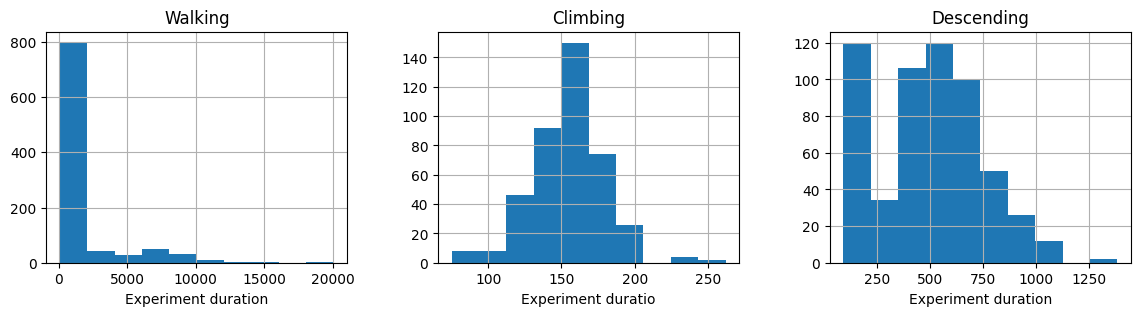

In [24]:
labels["Duration"] = labels["End_Point"] - labels["Start_Point"]
fig, axs = plt.subplots(1, 3, figsize=(14,3))
labels[labels["Act_ID"]==1].hist("Duration", ax=axs[0])
axs[0].set_title('Walking')
axs[0].set_xlabel("Experiment duration")
labels[labels["Act_ID"]==2].hist("Duration", ax=axs[1])
axs[1].set_title('Climbing')
axs[1].set_xlabel("Experiment duratio")
labels[labels["Act_ID"]==3].hist("Duration", ax=axs[2])
axs[2].set_title('Descending')
axs[2].set_xlabel("Experiment duration")

Here we note that the dataset is very unbalanced because the majority of the recorded data are in the walking category. In fact, a lot of the experiments in the walking category are larger than 5000 time steps.

Since the data will be windowed into short intervals for the detection model, this could make the vast majority of slices be in the walking category. This will likely make the model have a hard time learning the features of the other two categories.

So, we will remove all experiments larger than 5000 timesteps to limit the unbalancedness in the final dataset.

In [25]:
for i, row in labels.iterrows():
    if row["End_Point"] - row["Start_Point"] > 5000:
        labels.drop([i], axis=0, inplace=True)

Let us check the new histograms:

Text(0.5, 0, 'Experiment duration')

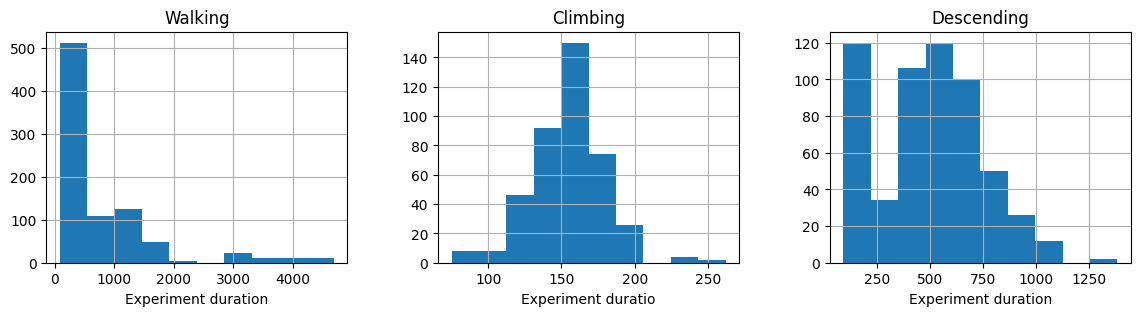

In [26]:
labels["Duration"] = labels["End_Point"] - labels["Start_Point"]
fig, axs = plt.subplots(1, 3, figsize=(14,3))
labels[labels["Act_ID"]==1].hist("Duration", ax=axs[0])
axs[0].set_title('Walking')
axs[0].set_xlabel("Experiment duration")
labels[labels["Act_ID"]==2].hist("Duration", ax=axs[1])
axs[1].set_title('Climbing')
axs[1].set_xlabel("Experiment duratio")
labels[labels["Act_ID"]==3].hist("Duration", ax=axs[2])
axs[2].set_title('Descending')
axs[2].set_xlabel("Experiment duration")


The next function takes a large time series and procudes several smaller series ones by windowing it with overlap.

In [27]:
# Windowing signals
def signal_windowing(data_dic, labels, window_size, overlap):
    # Creating a dictionary for each window with a keys: 'expAA_us_BB_act_C_D' where AA - experiment id, BB - user id,
    # C - activity id, D - window id
    win_dic = {}
    # Using only activities with index 1 - 3, transitions are not included
    sorted_labels = np.array(labels[labels['Act_ID'] < 4])
    # Window id, first is 0
    win_id = 0
    # Taking each sample from labels
    for sample in sorted_labels:
        # When id numbers are less then 10, add 0 before
        if sample[0] < 10:
            key_exp = '0' + str(sample[0])
        else:
            key_exp = str(sample[0])
        if sample[1] < 10:
            key_us = '0' + str(sample[1])
        else:
            key_us = str(sample[1])
        # Creating keys to use right dataframes for the user and the experiment number
        key = 'exp' + key_exp + '_user' + key_us
        # Start_Point from the sample
        start = int(sample[3])
        # End_Point
        end = int(sample[4])
        # Act_ID
        act_id = str(sample[2])
        # Windowing a signal described by the sample (from startpoint to endpoint), where the step is 128/2 = 64
        # bc the overlap is 50%

        
        for start_point in range(start, end-window_size+1, overlap):
            # Window size 128 cycles
            end_point = start_point + window_size - 1
            # Creating a key for the windows dictionary
            key_win = key + '_act' + act_id + '_' + str(win_id)
            # Windowing the signal data
            win_dic[key_win] = data_dic[key][start_point:end_point + 1]
            # Increasing the window id
            win_id+=1
    # Returning the windowing signal dicionary
    return win_dic

In order to detect activities in real time, the model has to be trained on time series with duration of 1-2 seconds.

Since our data was down-sampled to 128 Hz, 1 second correspond to 128 time steps in the data.

So, we will use a window of size 150, which correspond to ~1.2 seconds.

In [28]:
# Windowing the signal
win_dic = signal_windowing(raw_dic, labels, 150, 50)

Let's check the distribution of total time-steps for the windowed data. It should be concentrated at 150.

(array([    0.,     0.,     0.,     0.,     0., 15125.,     0.,     0.,
            0.,     0.]),
 array([149.5, 149.6, 149.7, 149.8, 149.9, 150. , 150.1, 150.2, 150.3,
        150.4, 150.5]),
 <BarContainer object of 10 artists>)

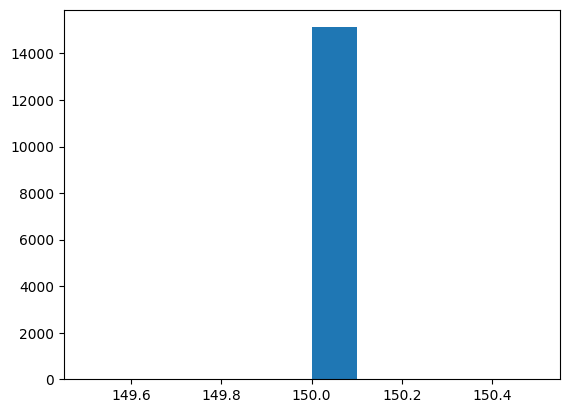

In [29]:
value_sizes = []
values = []

for key in win_dic.keys():
    value_sizes.append(win_dic[key].shape[0])
    values.append(np.array(win_dic[key]))

plt.hist(value_sizes)


The next function will generate the labels vector from the dictionary of windowed signals win_dic

In [30]:
# Function to generate output general data: with numbers of activities ID for each window and each sample in this window
def filter_labels(data):
    # Getting keys from the dictionary with the windowing signal
    keys = data.keys()
    # General dataframe with all act id for each window
    label_df = pd.DataFrame()
    # Dataframe to put ID value for one window
    act_df = pd.DataFrame()
    for key in keys:
        act_df['Act_ID'] = [int(key[16])]
        label_df = pd.concat([label_df,act_df],axis=0, ignore_index=True)
    return label_df

In [31]:
# Filtering labels and saving in the general_labels
general_labels = filter_labels(win_dic)

# Describing labels
general_labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15125 entries, 0 to 15124
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Act_ID  15125 non-null  int64
dtypes: int64(1)
memory usage: 118.3 KB


Check the head of labels

In [32]:
general_labels.head()

,Act_ID
0,1
1,1
2,1
3,1
4,1


Check the number of samples per activity category

In [33]:
# Visualising the labels dataset
# Histogram for actvities described by the windows with features
# 1 - Walking
# 2 - Stair Climbing
# 3 - Stair Descending
unique_labels, counts = np.unique(general_labels, return_counts =True)
counts

array([10581,   272,  4272], dtype=int64)

As we can see, the dataset is unbalaced with respect to the second category (stair climbing). This will likely affect the ability of the model in detecting this activity.

So, later,  we will augment the data within this category to train the model.

Next, we will prepare the data in a format which can be fed to the ML model. First, we will prepare the data as a numpy array.

In [34]:
samples = len(win_dic) # Number of samples
window_shape = win_dic['exp01_user01_act1_0'].shape[0] # Value of the window shape
components = win_dic['exp01_user01_act1_0'].shape[1] # Number of components

# Keys from the data dictionary
keys = list(win_dic.keys())


Expected data shape

In [35]:
print('DATA SHAPE: [' + str(samples) + ', ' + str(window_shape) + ', ' + str(components) + ']' )

DATA SHAPE: [15125, 150, 7]


Transform to numpy array:

In [36]:
# Save reshaped data from the win_dic with the shape (samples,window_shape,components)
general_data = np.empty(shape = (samples,window_shape,components))

for i in range(samples):
    values = win_dic[keys[i]].values
    if values.shape != (150, 7):
        continue  # Skip the current iteration if shape is not (128, 7)
    general_data[i] = values

print(general_data.shape)


(15125, 150, 7)


Now normalize the dataset to facilitate fitting later

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
general_data = scaler.fit_transform(general_data.reshape(-1, general_data.shape[-1])).reshape(general_data.shape)


Next, we will augment the samples with activity label 2 (stair climbing) and label 3 (stair descending) to make the whole dataset more balanced.

In [38]:
import tsaug
import random

# Separate indices per activity type
walk_idx = np.where(general_labels==1)[0]
climb_idx = np.where(general_labels==2)[0]
desc_idx = np.where(general_labels==3)[0]

data2 = general_data[climb_idx]
keys2 = [keys[i] for i in climb_idx]
keys2_aug = []
labels2 = general_labels.iloc[climb_idx]
n_samples, timesteps, channels = data2.shape

# How many time the data will be augmented
aug_factor = 30

# Array where augmented data will be stored for label = 2
data2_aug = np.zeros((aug_factor*n_samples, timesteps, channels))

# Augmentation loop
for exp in range(n_samples):
    for aug in range(aug_factor):
        for channel in range(channels):
            data2_aug[exp+aug,:,channel] = tsaug.TimeWarp(n_speed_change=random.randint(1,3), max_speed_ratio=random.randint(2,5)).augment(data2[exp, :, channel])
        keys2_aug.append(keys2[exp]+'_'+str(aug))

labels2_aug = pd.concat([labels2]*aug_factor)


data3 = general_data[desc_idx]
keys3 = [keys[i] for i in desc_idx]
keys3_aug = []
labels3 = general_labels.iloc[desc_idx]
n_samples, timesteps, channels = data3.shape

# How many time the data will be augmented
aug_factor = 1

# Array where augmented data will be stored for label = 3
data3_aug = np.zeros((aug_factor*n_samples, timesteps, channels))

# Augmentation loop
for exp in range(n_samples):
    for aug in range(aug_factor):
        for channel in range(channels):
            data3_aug[exp+aug,:,channel] = tsaug.TimeWarp(n_speed_change=random.randint(1,3), max_speed_ratio=random.randint(2,5)).augment(data3[exp, :, channel])
        keys3_aug.append(keys3[exp]+'_'+str(aug))

labels3_aug = pd.concat([labels3]*aug_factor)

_keys = keys + keys2_aug + keys3_aug
aug_data = np.concatenate((general_data, data2_aug, data3_aug))
aug_label = pd.concat([general_labels, labels2_aug, labels3_aug])

len(_keys)

27557

Now let's visualize the data for each activity category for samples chosen randomly 

C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1965189201.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx1 = int(np.random.choice(walk_idx,1))
C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1965189201.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx2 = int(np.random.choice(climb_idx,1))
C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1965189201.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx3 = int(np.random.choice(desc_idx,1))


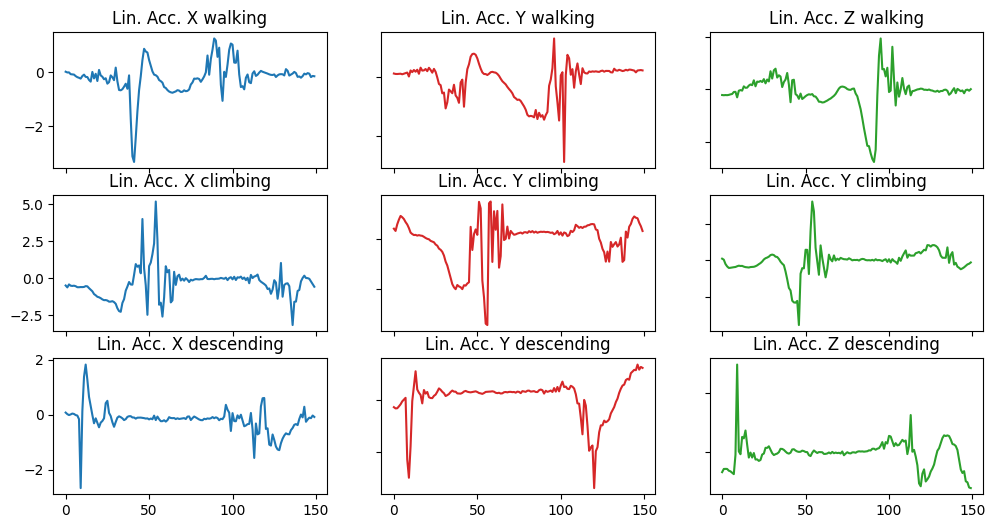

In [39]:
idx1 = int(np.random.choice(walk_idx,1))
idx2 = int(np.random.choice(climb_idx,1))
idx3 = int(np.random.choice(desc_idx,1))

fig, axs = plt.subplots(3, 3, figsize=(12,6))
axs[0, 0].plot(general_data[idx1,:,0])
axs[0, 0].set_title('Lin. Acc. X walking')
axs[0, 1].plot(general_data[idx1,:,1], 'tab:red')
axs[0, 1].set_title('Lin. Acc. Y walking')
axs[0, 2].plot(general_data[idx1,:,2], 'tab:green')
axs[0, 2].set_title('Lin. Acc. Z walking')

axs[1, 0].plot(general_data[idx2,:,0])
axs[1, 0].set_title('Lin. Acc. X climbing')
axs[1, 1].plot(general_data[idx2,:,1], 'tab:red')
axs[1, 1].set_title('Lin. Acc. Y climbing')
axs[1, 2].plot(general_data[idx2,:,2], 'tab:green')
axs[1, 2].set_title('Lin. Acc. Y climbing')

axs[2, 0].plot(general_data[idx3,:,0])
axs[2, 0].set_title('Lin. Acc. X descending')
axs[2, 1].plot(general_data[idx3,:,1], 'tab:red')
axs[2, 1].set_title('Lin. Acc. Y descending')
axs[2, 2].plot(general_data[idx3,:,2], 'tab:green')
axs[2, 2].set_title('Lin. Acc. Z descending')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1857632291.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx1 = int(np.random.choice(walk_idx,1))
C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1857632291.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx2 = int(np.random.choice(climb_idx,1))
C:\Users\paolo\AppData\Local\Temp\ipykernel_13860\1857632291.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx3 = int(np.random.choice(desc_idx,1))


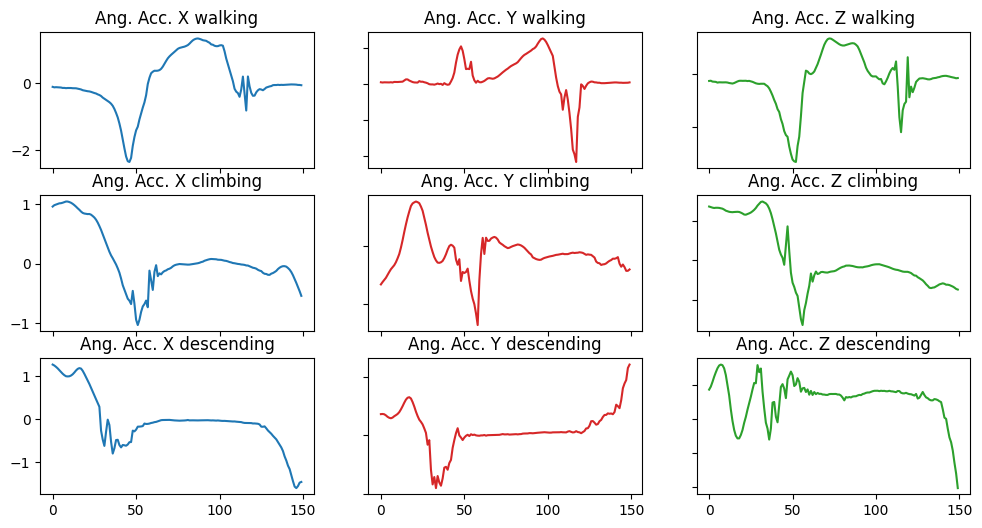

In [40]:
idx1 = int(np.random.choice(walk_idx,1))
idx2 = int(np.random.choice(climb_idx,1))
idx3 = int(np.random.choice(desc_idx,1))

fig, axs = plt.subplots(3, 3,figsize=(12,6))
axs[0, 0].plot(general_data[idx1,:,3])
axs[0, 0].set_title('Ang. Acc. X walking')
axs[0, 1].plot(general_data[idx1,:,4], 'tab:red')
axs[0, 1].set_title('Ang. Acc. Y walking')
axs[0, 2].plot(general_data[idx1,:,5], 'tab:green')
axs[0, 2].set_title('Ang. Acc. Z walking')

axs[1, 0].plot(general_data[idx2,:,3])
axs[1, 0].set_title('Ang. Acc. X climbing')
axs[1, 1].plot(general_data[idx2,:,4], 'tab:red')
axs[1, 1].set_title('Ang. Acc. Y climbing')
axs[1, 2].plot(general_data[idx2,:,5], 'tab:green')
axs[1, 2].set_title('Ang. Acc. Z climbing')

axs[2, 0].plot(general_data[idx3,:,3])
axs[2, 0].set_title('Ang. Acc. X descending')
axs[2, 1].plot(general_data[idx3,:,4], 'tab:red')
axs[2, 1].set_title('Ang. Acc. Y descending')
axs[2, 2].plot(general_data[idx3,:,5], 'tab:green')
axs[2, 2].set_title('Ang. Acc. Z descending')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Check the distribution of labels of the augmented dataset to make sure it is balanced

In [43]:
unique_labels, counts = np.unique(aug_label, return_counts =True)
counts

array([10581,  8432,  8544], dtype=int64)

We now shuffle the augmented dataset to make the order in which different labels appear be uniformly distributed

In [44]:
shuffle_index = np.arange(len(aug_label))
np.random.shuffle(shuffle_index)
__keys = []
_general_data = aug_data.copy()
_general_labels =  aug_label.copy()

for i in range(len(aug_label)):
    __keys.append(_keys[shuffle_index[i]])
    _general_data[i] = aug_data[shuffle_index[i]]
    _general_labels.iloc[i] = aug_label.iloc[shuffle_index[i]]
    

Finally, we define and train the ML model.

We take the CNN model in Zhang et al (2015) as the first part in our model. The goal of the CNN is to preprocess the time-series vectors which are then fed to a LSTM unit. 

The combined CNN + LSTM has better accuracy when compared to a pure CNN or LSTM model.

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Softmax, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

Testing with user 01...
Epoch 1/30
669/669 [==============================] - 32s 41ms/step - loss: 0.3663 - accuracy: 0.9409 - val_loss: 0.2870 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 2/30
669/669 [==============================] - 26s 39ms/step - loss: 0.2762 - accuracy: 0.9633 - val_loss: 0.2392 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 3/30
669/669 [==============================] - 25s 37ms/step - loss: 0.2428 - accuracy: 0.9673 - val_loss: 0.2233 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 4/30
669/669 [==============================] - 27s 41ms/step - loss: 0.2295 - accuracy: 0.9660 - val_loss: 0.2243 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 5/30
669/669 [==============================] - 27s 40ms/step - loss: 0.2194 - accuracy: 0.9699 - val_loss: 0.2380 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 6/30
669/669 [==============================] - 27s 40ms/step - loss: 0.2258 - accuracy: 0.9666 - val_loss: 0.2503 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 7/30
669/669 [==============

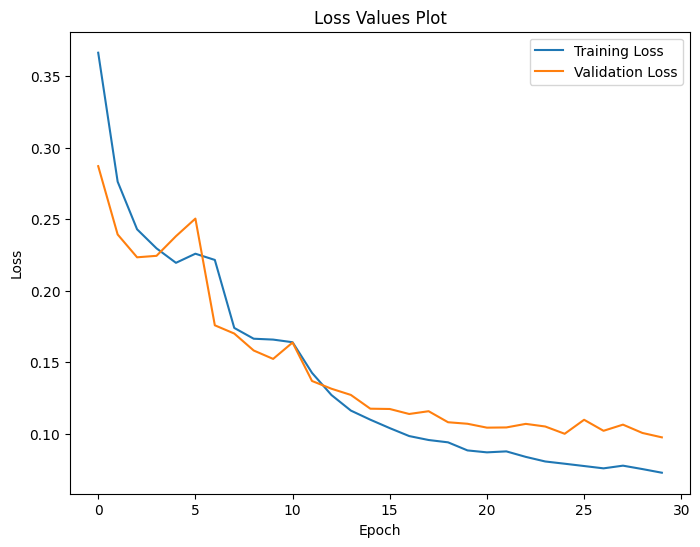

Testing with user 02...
Epoch 1/30
615/615 [==============================] - 27s 42ms/step - loss: 0.4352 - accuracy: 0.9222 - val_loss: 0.3412 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 2/30
615/615 [==============================] - 25s 41ms/step - loss: 0.3211 - accuracy: 0.9505 - val_loss: 0.2705 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/30
615/615 [==============================] - 25s 41ms/step - loss: 0.2949 - accuracy: 0.9516 - val_loss: 0.2762 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 4/30
615/615 [==============================] - 25s 41ms/step - loss: 0.2779 - accuracy: 0.9535 - val_loss: 0.2504 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 5/30
615/615 [==============================] - 25s 41ms/step - loss: 0.2753 - accuracy: 0.9531 - val_loss: 0.2662 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 6/30
615/615 [==============================] - 25s 41ms/step - loss: 0.2800 - accuracy: 0.9524 - val_loss: 0.2736 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 7/30
615/615 [==============

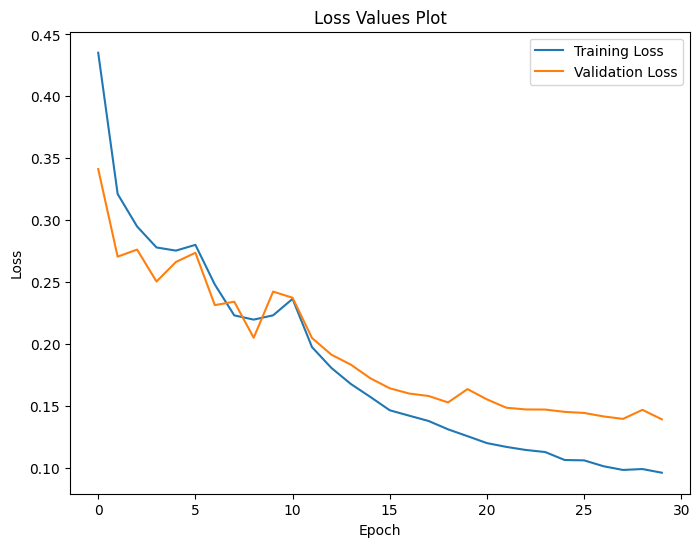

Testing with user 03...
Epoch 1/30
607/607 [==============================] - 29s 45ms/step - loss: 0.4361 - accuracy: 0.9234 - val_loss: 0.3709 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 2/30
607/607 [==============================] - 26s 44ms/step - loss: 0.3337 - accuracy: 0.9497 - val_loss: 0.3099 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/30
607/607 [==============================] - 26s 43ms/step - loss: 0.3052 - accuracy: 0.9496 - val_loss: 0.2531 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/30
607/607 [==============================] - 26s 43ms/step - loss: 0.2710 - accuracy: 0.9535 - val_loss: 0.2556 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 5/30
607/607 [==============================] - 26s 44ms/step - loss: 0.2781 - accuracy: 0.9529 - val_loss: 0.2595 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 6/30
607/607 [==============================] - 26s 43ms/step - loss: 0.2689 - accuracy: 0.9532 - val_loss: 0.2624 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 7/30
607/607 [==============

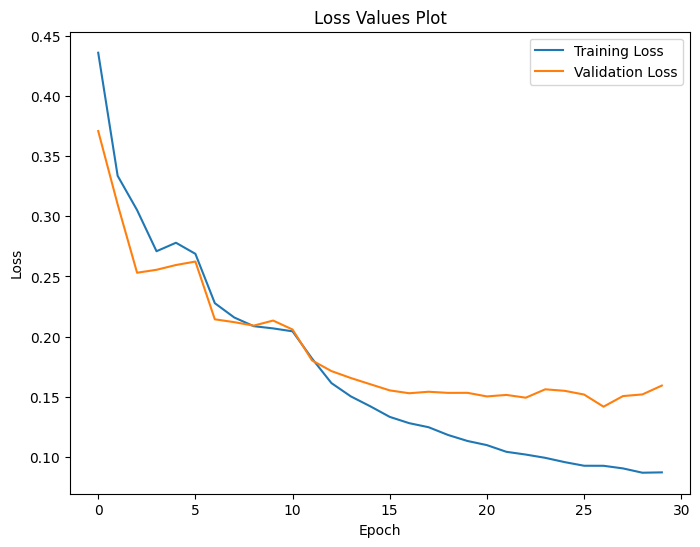

Testing with user 04...
Epoch 1/30
636/636 [==============================] - 29s 44ms/step - loss: 0.4191 - accuracy: 0.9284 - val_loss: 0.2960 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 2/30
636/636 [==============================] - 27s 42ms/step - loss: 0.3052 - accuracy: 0.9556 - val_loss: 0.2656 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 3/30
636/636 [==============================] - 27s 42ms/step - loss: 0.2925 - accuracy: 0.9537 - val_loss: 0.2418 - val_accuracy: 0.9646 - lr: 0.0010
Epoch 4/30
636/636 [==============================] - 27s 43ms/step - loss: 0.2701 - accuracy: 0.9565 - val_loss: 0.2446 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 5/30
636/636 [==============================] - 27s 42ms/step - loss: 0.2676 - accuracy: 0.9552 - val_loss: 0.2318 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 6/30
636/636 [==============================] - 26s 40ms/step - loss: 0.2550 - accuracy: 0.9575 - val_loss: 0.2356 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 7/30
636/636 [==============

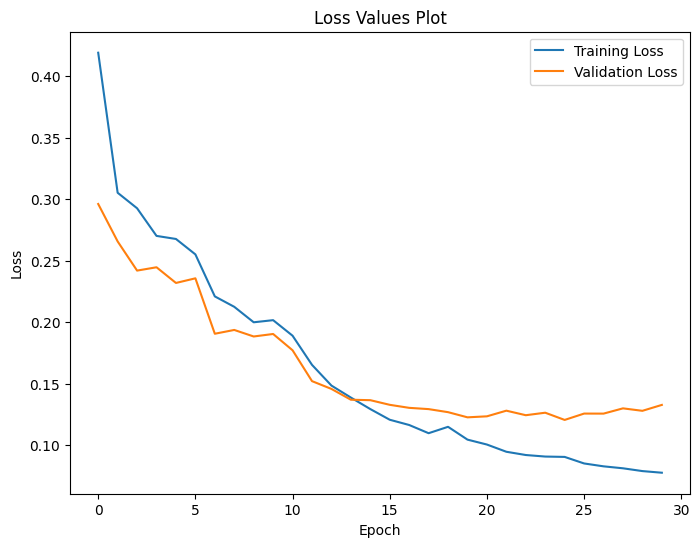

Testing with user 05...
Epoch 1/30
625/625 [==============================] - 29s 44ms/step - loss: 0.4146 - accuracy: 0.9289 - val_loss: 0.3131 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 27s 43ms/step - loss: 0.3079 - accuracy: 0.9518 - val_loss: 0.2880 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 25s 41ms/step - loss: 0.2802 - accuracy: 0.9545 - val_loss: 0.2588 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 25s 40ms/step - loss: 0.2695 - accuracy: 0.9543 - val_loss: 0.2649 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 25s 41ms/step - loss: 0.3041 - accuracy: 0.9524 - val_loss: 0.2611 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 26s 41ms/step - loss: 0.2682 - accuracy: 0.9554 - val_loss: 0.2621 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 7/30
625/625 [==============

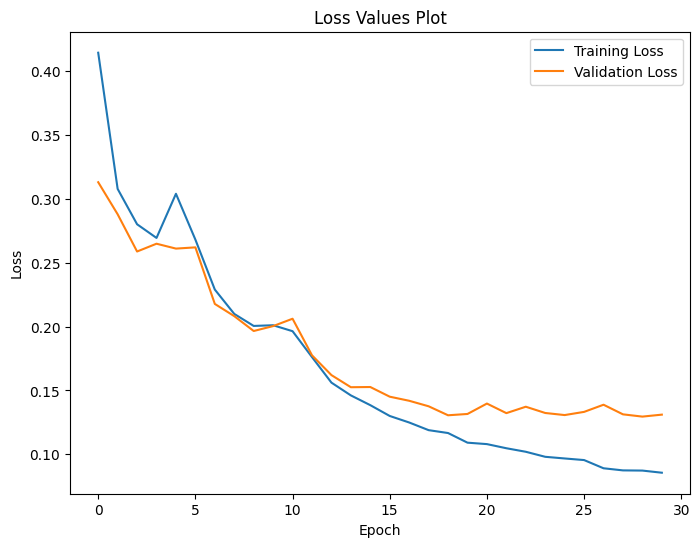

Testing with user 06...
Epoch 1/30
594/594 [==============================] - 28s 43ms/step - loss: 0.4343 - accuracy: 0.9226 - val_loss: 0.3242 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 2/30
594/594 [==============================] - 25s 42ms/step - loss: 0.3166 - accuracy: 0.9507 - val_loss: 0.2741 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 3/30
594/594 [==============================] - 26s 43ms/step - loss: 0.2825 - accuracy: 0.9522 - val_loss: 0.2666 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/30
594/594 [==============================] - 26s 44ms/step - loss: 0.2677 - accuracy: 0.9543 - val_loss: 0.2599 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 5/30
594/594 [==============================] - 25s 43ms/step - loss: 0.2588 - accuracy: 0.9543 - val_loss: 0.2361 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 6/30
594/594 [==============================] - 25s 42ms/step - loss: 0.2602 - accuracy: 0.9544 - val_loss: 0.2426 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 7/30
594/594 [==============

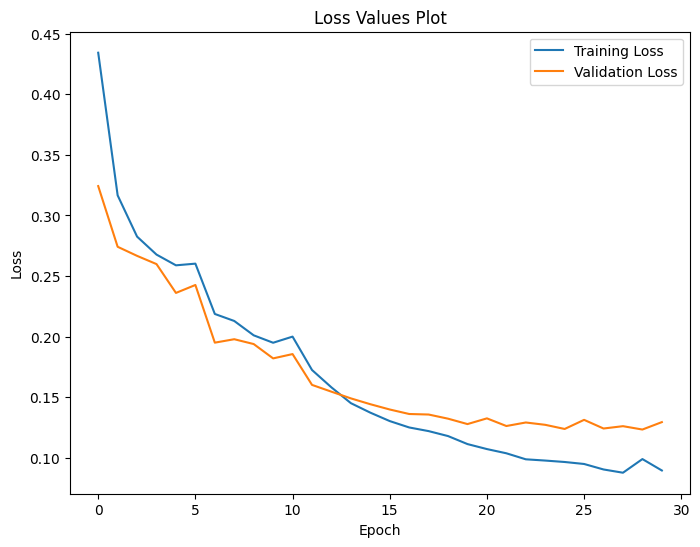

Testing with user 07...
Epoch 1/30
607/607 [==============================] - 27s 42ms/step - loss: 0.4105 - accuracy: 0.9279 - val_loss: 0.3121 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 2/30
607/607 [==============================] - 25s 42ms/step - loss: 0.3024 - accuracy: 0.9555 - val_loss: 0.2623 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 3/30
607/607 [==============================] - 26s 42ms/step - loss: 0.2782 - accuracy: 0.9559 - val_loss: 0.2391 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 4/30
607/607 [==============================] - 26s 43ms/step - loss: 0.2582 - accuracy: 0.9582 - val_loss: 0.2236 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/30
607/607 [==============================] - 26s 43ms/step - loss: 0.2620 - accuracy: 0.9595 - val_loss: 0.2339 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/30
607/607 [==============================] - 26s 43ms/step - loss: 0.2701 - accuracy: 0.9586 - val_loss: 0.2766 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 7/30
607/607 [==============

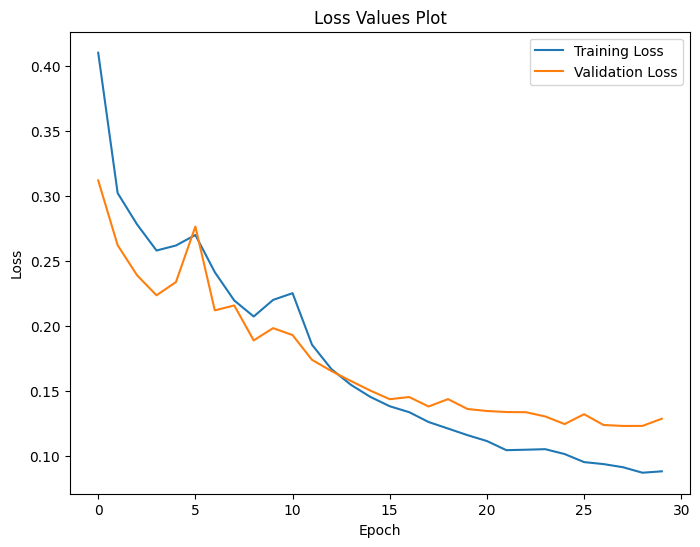

Testing with user 08...
Epoch 1/30
634/634 [==============================] - 29s 43ms/step - loss: 0.3877 - accuracy: 0.9375 - val_loss: 0.2859 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 2/30
634/634 [==============================] - 27s 42ms/step - loss: 0.2876 - accuracy: 0.9593 - val_loss: 0.2533 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/30
634/634 [==============================] - 27s 43ms/step - loss: 0.2631 - accuracy: 0.9596 - val_loss: 0.2377 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 4/30
634/634 [==============================] - 27s 43ms/step - loss: 0.2462 - accuracy: 0.9605 - val_loss: 0.2393 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/30
634/634 [==============================] - 27s 43ms/step - loss: 0.2388 - accuracy: 0.9625 - val_loss: 0.2293 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 6/30
634/634 [==============================] - 28s 44ms/step - loss: 0.2409 - accuracy: 0.9621 - val_loss: 0.2288 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 7/30
634/634 [==============

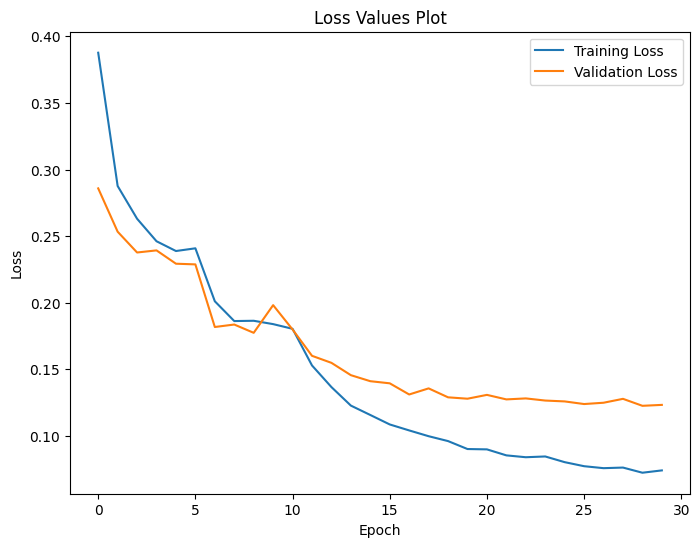

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 146, 32)           1152      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 73, 32)           0         
 g1D)                                                            
                                                                 
 activation_21 (Activation)  (None, 73, 32)            0         
                                                                 
 batch_normalization_21 (Bat  (None, 73, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_22 (Conv1D)          (None, 69, 64)            10304     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 34, 64)          

In [46]:
epochs = 30
batch_size = 32
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

# List of user IDs
user_ids = ['01', '02', '03', '04', '05', '06', '07', '08']

accuracies = []

# Initialize lists to collect results
classification_reports = []
confusion_matrices = []

for test_user in user_ids:

    print(f"Testing with user {test_user}...")

    # Split the data into training and testing sets
    train_data = np.array([i for i, key in enumerate(_keys) if test_user not in key])
    test_data = np.array([i for i, key in enumerate(_keys) if test_user in key])

    # Reshaping X data into (samples, windows-shape, compontents) values from the SingalPreprocessing
    samples = train_data.size
    samples_test = test_data.size
    window_shape = 150
    components = 7

    X_train = np.reshape(_general_data[train_data], (samples, window_shape, components))
    X_test = np.reshape(_general_data[test_data], (samples_test, window_shape, components))

    # y data
    y_train = _general_labels.iloc[train_data]
    y_test = _general_labels.iloc[test_data]

    # Changing the y type (int) and decrease the indexes by one - to fit it with binary class matrix (output
    y_train = y_train.astype(int) - 1
    y_test = y_test.astype(int) - 1

    # Convert labels to one-hot encoded format
    train_labels_one_hot = to_categorical(y_train, num_classes=3)
    test_labels_one_hot = to_categorical(y_test, num_classes=3)

    # Create and compile CNN model
    nr_filter_1 = 32
    nr_kernel_1 = 5
    nr_filter_2 = 64
    nr_kernel_2 = 5
    nr_filter_3 = 1024
    nr_kernel_3 = 5

    # Define Sequential model
    model = keras.models.Sequential()

    # First Conv Block
    model.add(Conv1D(filters=nr_filter_1, kernel_size=nr_kernel_1, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())


    # Second Conv Block
    model.add(Conv1D(filters=nr_filter_2, kernel_size=nr_kernel_2, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())


    # Third Conv Block
    model.add(Conv1D(filters=nr_filter_3, kernel_size=nr_kernel_3, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    # Dropout and flattening layer
    model.add(Dropout(0.5))
    #model.add(Flatten())

    # First and second dense layers
    #model.add(Dense(units=125, activation='softplus', kernel_regularizer=l2(0.01)))
    #model.add(Dense(units=3, activation='softmax', kernel_regularizer=l2(0.01))) #3 units = 3
    model.add(LSTM(3, activation="softmax", recurrent_activation="sigmoid"))
    
    # Compile the model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # early_stopping
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, train_labels_one_hot, shuffle=True,epochs=epochs , batch_size=batch_size, validation_split=0.1, callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, test_labels_one_hot)
    # Append the accuracy to the list
    accuracies.append(test_accuracy)

    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Evaluate the model on the test data
    y_true = _general_labels.iloc[test_data]
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)


    # Get the classification report and confusion matrix
    class_names = ['walk', 'Stair_clmb', 'Stair_dscnt']
    class_report = classification_report(np.argmax(test_labels_one_hot, axis=1), y_pred_classes, target_names=class_names)
    print("Classification Report:")
    print(class_report)

    confusion_mat = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), y_pred_classes)
    print("Confusion Matrix:")
    print(confusion_mat)

    # Store results
    classification_reports.append(class_report)
    confusion_matrices.append(confusion_mat)

    # Plot the loss values during training
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Values Plot')
    plt.legend()
    plt.show()

# Summary of the model
model.summary()


# Combine all individual class reports
combined_class_reports = '\n'.join(classification_reports)

# Calculate the average classification report
# Split the combined report into lines
report_lines = combined_class_reports.strip().split('\n')

# Initialize dictionaries to store cumulative metrics
avg_precision = {}
avg_recall = {}
avg_f1_score = {}
avg_support = {}

# Process each line in the report
for line in report_lines[2:]:
    parts = line.split()

    if len(parts) >= 5 and parts[0] in class_names:
        class_name = parts[0]
        precision = float(parts[1])
        recall = float(parts[2])
        f1_score = float(parts[3])
        support = float(parts[4])

        avg_precision[class_name] = avg_precision.get(class_name, 0) + precision
        avg_recall[class_name] = avg_recall.get(class_name, 0) + recall
        avg_f1_score[class_name] = avg_f1_score.get(class_name, 0) + f1_score
        avg_support[class_name] = avg_support.get(class_name, 0) + support

# Calculate the average accuracy
average_accuracy = sum(accuracies) / len(user_ids)

# Print the average accuracy
print("Average Accuracy: {:.2f}".format(average_accuracy))

# Calculate the actual averages
for class_name in avg_precision:
    avg_precision[class_name] /= len(user_ids)
    avg_recall[class_name] /= len(user_ids)
    avg_f1_score[class_name] /= len(user_ids)
    avg_support[class_name] /= len(user_ids)

# Print the average classification report
print("Average Classification Report:")
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1-Score', 'Support'))
for class_name in class_names:
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(class_name, avg_precision[class_name], avg_recall[class_name], avg_f1_score[class_name], avg_support[class_name]))


# Convert confusion matrices to numpy arrays
confusion_matrices_np = np.array(confusion_matrices)

# Calculate the average confusion matrix
average_confusion_mat = np.mean(confusion_matrices_np, axis=0)

# Print the average confusion matrix
print("Average Confusion Matrix:")
print(average_confusion_mat)